In [66]:
import pandas as pd 
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import combinations
from statsmodels.tsa.stattools import coint   


In [67]:
close = pd.read_csv('../data/close_prices.csv')
print(close.columns)

Index(['Date', 'AAPL', 'AMZN', 'AVGO', 'GOOGL', 'META', 'MSFT', 'NFLX', 'NVDA',
       'ORCL', 'QQQ', 'SPY', 'TSLA'],
      dtype='object')


In [68]:
# test on lstm outputs first
folder_path = "../LSTM/outputs"

prediction_files = glob.glob(os.path.join(folder_path, "*_predictions.csv"))

dfs = {}
for file in prediction_files:
    name = os.path.basename(file).replace("_predictions.csv", "")
    dfs[name] = pd.read_csv(file)


all_predictions = pd.concat(
    [df.assign(stock=name) for name, df in dfs.items()],
    ignore_index=True
)

In [69]:
predicted = (
    all_predictions
    .pivot(index="Date", columns="stock", values="PredictedPrice")
    .reset_index()
)
display(predicted.head())

stock,Date,AAPL,AMZN,AVGO,GOOGL,META,MSFT,NFLX,NVDA,ORCL,QQQ,SPY,TSLA
0,2023-01-03,114.519516,78.36307,33.496550,63.563602,155.53108,195.68138,304.99542,13.643364,53.049305,165.93988,274.80026,107.360420
1,2023-01-04,113.716484,78.91684,33.637490,63.808025,155.41907,196.17316,305.21637,13.630103,53.495940,165.78568,274.28726,112.083360
2,2023-01-05,113.074950,79.44042,33.770462,63.931328,155.22202,196.40758,307.19970,13.620599,53.997230,165.78750,273.61750,118.941246
3,2023-01-06,112.474890,79.90562,33.872746,64.022820,154.95824,196.31615,310.08636,13.621037,54.468426,165.78844,272.39505,127.969570
4,2023-01-09,112.014720,80.20997,34.276447,64.002650,154.82167,196.01443,313.29813,13.635827,54.990013,166.02893,271.67776,138.273740


# Pairs Selection

In [70]:
close_train = close[close["Date"] < "2023-01-01"].set_index("Date")
log_prices = np.log(close_train)

# correlation
corr_matrix = log_prices.corr()
threshold = 0.8
candidates = [
    (i, j) for i, j in combinations(log_prices.columns, 2)
    if corr_matrix.loc[i, j] > threshold
]

pairs = []
min_len = 200 

for s1, s2 in candidates:
    df_pair = pd.concat(
        [log_prices[s1], log_prices[s2]],
        axis=1,
        keys=[s1, s2]
    ).dropna()

    if len(df_pair) < min_len:
        continue

    # cointegration
    score, pvalue, _ = coint(df_pair[s1], df_pair[s2])
    if pvalue < 0.05:
        x = df_pair[s2].values
        y = df_pair[s1].values

        X = np.column_stack([np.ones(len(x)), x])
        # least squares
        beta_hat = np.linalg.lstsq(X, y, rcond=None)[0]  
        alpha = beta_hat[0]
        beta = beta_hat[1]

        spread = df_pair[s1] - beta * df_pair[s2]

        mu = spread.mean()
        sigma = spread.std()

        pairs.append((s1, s2, pvalue, alpha, beta, mu, sigma))

pairs = sorted(pairs, key=lambda x: x[2])

for p in pairs[:5]:
    s1, s2, pval, alpha, beta, mu, sigma = p
    print(f"{s1} - {s2} | p={pval:.4f} | beta={beta:.4f} | mu={mu:.4f} | sigma={sigma:.4f}")


GOOGL - SPY | p=0.0007 | beta=1.4820 | mu=-4.1332 | sigma=0.0878
ORCL - SPY | p=0.0079 | beta=0.7933 | mu=-0.5182 | sigma=0.0811
GOOGL - ORCL | p=0.0130 | beta=1.7858 | mu=-2.8649 | sigma=0.1762
AAPL - ORCL | p=0.0139 | beta=2.2316 | mu=-4.6513 | sigma=0.2351
GOOGL - QQQ | p=0.0180 | beta=1.0806 | mu=-1.5033 | sigma=0.0958


In [71]:
pair_df = pd.DataFrame(
    pairs,
    columns=["stock1", "stock2", "pvalue", "alpha", "beta", "mu", "sigma"]
)

pair_df = pair_df.sort_values("pvalue").reset_index(drop=True)

# Back test


In [90]:
def backtest_pair(pred_df, actual_df, pair_row, z_entry=1.0, z_exit=0.5):
    """
    pred_df  : DataFrame with columns ['Date', s1, s2]
    actual_df: DataFrame with columns ['Date', s1, s2]
    pair_row : {'stock1','stock2','beta','mu','sigma'}
    """
    s1 = pair_row["stock1"]; s2 = pair_row["stock2"]
    beta = float(pair_row["beta"]); mu = float(pair_row["mu"]); sigma = float(pair_row["sigma"])

    pred = pred_df[["Date", s1, s2]].dropna().copy()
    act  = actual_df[["Date", s1, s2]].dropna().copy()
    pred["Date"] = pd.to_datetime(pred["Date"]); act["Date"] = pd.to_datetime(act["Date"])
    pred = pred.set_index("Date").sort_index()
    act  = act.set_index("Date").sort_index()
    idx = pred.index.intersection(act.index)
    pred = pred.loc[idx]; act = act.loc[idx]

    # spread and z
    spread_pred = np.log(pred[s1]) - beta * np.log(pred[s2])
    z = (spread_pred - mu) / sigma

    pos1, pos2 = [], []
    cur1 = 0.0; cur2 = 0.0
    for zi in z:
        if zi > z_entry:          
            cur1, cur2 = -1.0, +beta
        elif zi < -z_entry:     
            cur1, cur2 = +1.0, -beta
        elif abs(zi) < z_exit:   
            cur1, cur2 = 0.0, 0.0
        pos1.append(cur1); pos2.append(cur2)

    out = pd.DataFrame({
        "price_"+s1: act[s1],
        "price_"+s2: act[s2],
        "spread": spread_pred,
        "z": z,
        "pos_"+s1: pos1,
        "pos_"+s2: pos2,
    }, index=idx)

    r1 = np.log(act[s1]).diff()
    r2 = np.log(act[s2]).diff()

    pos1 = out["pos_"+s1].fillna(0.0)
    pos2 = out["pos_"+s2].fillna(0.0)

    strat_ret = (pos1 * r1 + pos2 * r2).fillna(0.0)
    out["strategy_ret"] = strat_ret
    out["cumret"] = out["strategy_ret"].cumsum()

    return out



In [78]:
def plot_pair_performance(res, pair_row):

    s1, s2 = pair_row["stock1"], pair_row["stock2"]

    res = res.copy()
    if 'Date' in res.columns:
        res['Date'] = pd.to_datetime(res['Date'], errors='coerce')
        res = res.set_index('Date')
    else:
        if not pd.api.types.is_datetime64_any_dtype(res.index):
            try:
                res.index = pd.to_datetime(res.index, errors='raise')
            except Exception:
                if pd.api.types.is_integer_dtype(res.index):
                    res.index = pd.to_datetime(res.index, unit='D', origin='unix')
                else:
                    raise ValueError("Index is not datetime-like and no 'Date' column found.")
    res.index.name = 'Date'

    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(res.index, res["cumret"], color="royalblue", linewidth=2, label="Cumulative Return")
    ax1.set_xlabel("Date", fontsize=12)
    ax1.set_ylabel("Cumulative Log Return", fontsize=12, color="royalblue")
    ax1.tick_params(axis='y', labelcolor='royalblue')

    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    plt.title(f"Pair Trading Performance: {s1} vs {s2}", fontsize=14, weight='bold')
    plt.grid(alpha=0.3, linestyle="--", linewidth=0.7)
    ax1.legend(loc="upper left")

    plt.tight_layout()
    plt.show()



In [74]:

def compute_pair_metrics(res):

    daily_ret = res["strategy_ret"].dropna()
    n_days = len(daily_ret)

    if n_days == 0:
        return {
            "CumulativeReturn": np.nan,
            "AnnualizedReturn": np.nan,
            "AnnualVolatility": np.nan,
            "SharpeRatio": np.nan,
            "MaxDrawdown": np.nan,
            "WinRate": np.nan,
            "Days": 0,
        }

    final_cumlog = res["cumret"].iloc[-1]

    total_return = np.exp(final_cumlog) - 1

    ann_return = (1 + total_return) ** (252 / n_days) - 1

    daily_std = daily_ret.std()
    ann_vol = daily_std * np.sqrt(252)


    if daily_std == 0:
        sharpe = np.nan
    else:
        sharpe = daily_ret.mean() / daily_std * np.sqrt(252)

    equity = np.exp(res["cumret"])            
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    max_dd = drawdown.min()

   
    win_rate = (daily_ret > 0).mean()

    return {
        "CumulativeReturn": total_return,   
        "AnnualizedReturn": ann_return,
        "AnnualVolatility": ann_vol,
        "SharpeRatio": sharpe,
        "MaxDrawdown": max_dd,
        "WinRate": win_rate,
        "Days": n_days,
    }



# Buy and Hold

In [96]:
def buyhold_benchmark_neutral(actual_df, pair_row):
    s1, s2, beta = pair_row["stock1"], pair_row["stock2"], float(pair_row["beta"])
    tmp = actual_df[["Date", s1, s2]].dropna().copy()
    tmp["Date"] = pd.to_datetime(tmp["Date"])
    tmp = tmp.set_index("Date").sort_index()

    r1 = np.log(tmp[s1]).diff()
    r2 = np.log(tmp[s2]).diff()

    bh_ret = (r1 - beta * r2).fillna(0.0)
    out = pd.DataFrame({
        "strategy_ret": bh_ret,
        "cumret": bh_ret.cumsum()
    }, index=tmp.index)
    return out



# Test

In [ ]:
def plot_strategy_vs_benchmark(res_strategy, res_bh, title="Strategy vs Buy&Hold (Neutral)"):
    plt.figure(figsize=(10,5))
    idx = res_strategy.index.intersection(res_bh.index)
    plt.plot(idx, res_strategy.loc[idx, "cumret"], label="Pairs Trading")
    plt.plot(idx, res_bh.loc[idx, "cumret"], label="Buy&Hold Neutral", linestyle="--")
    plt.ylabel("Cumulative Log Return")
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


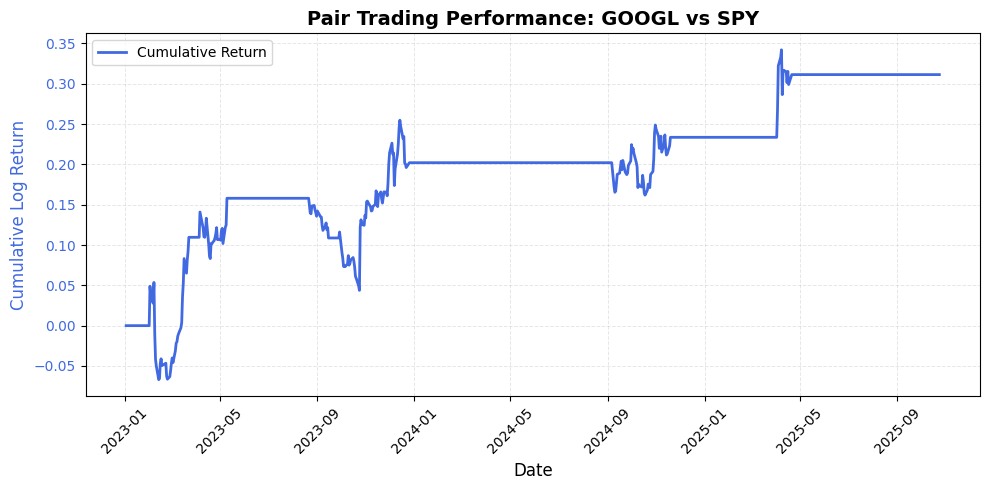

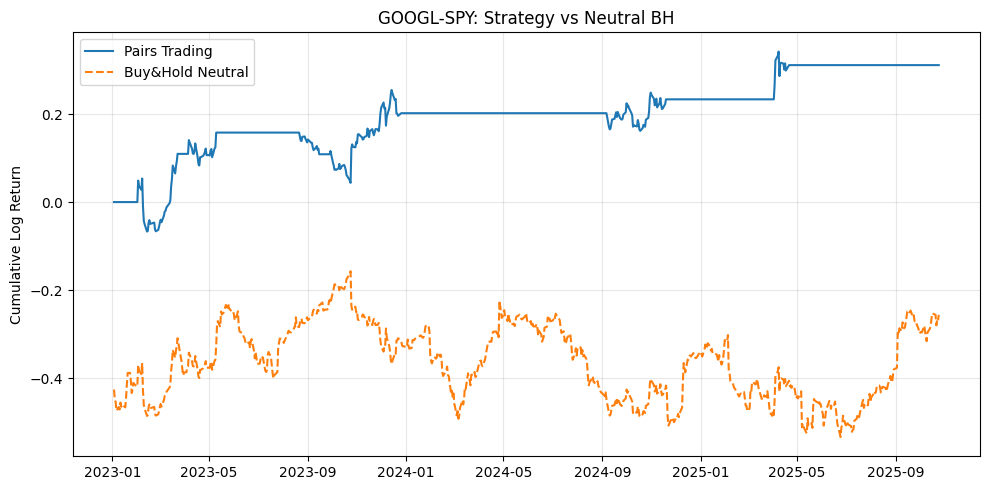

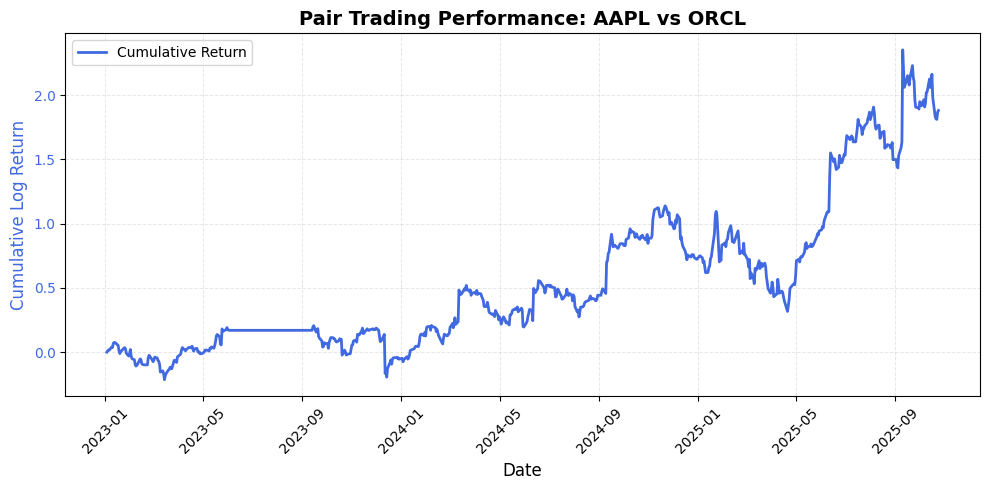

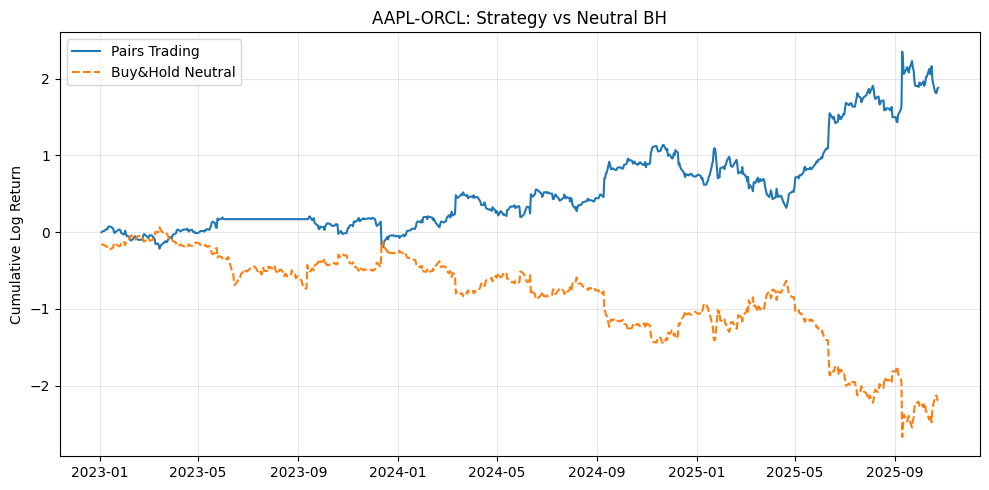

== Strategy vs Neutral Buy&Hold (aligned)==


,Strat_CumRet,Strat_AnnRet,Strat_AnnVol,Strat_Sharpe,Strat_MaxDD,Strat_WinRt,BH_CumRet,BH_AnnRet,BH_AnnVol,BH_Sharpe,BH_MaxDD,BH_WinRt,Days
Pair,,,,,,,,,,,,,
GOOGL-SPY,0.3652,0.1175,0.1355,0.8203,-0.1136,0.1572,-0.2261,-0.0874,0.2485,0.2674,-0.3139,0.5212,706
AAPL-ORCL,5.5565,0.9566,0.8661,0.7749,-0.5602,0.4915,-0.8888,-0.5434,0.9048,-0.8436,-0.9350,0.4490,706


== Excess (Strategy - BH-Neutral) ==


,Excess_AnnRet,Excess_Sharpe,Excess_CumRet
Pair,,,
GOOGL-SPY,0.2050,0.5530,0.5914
AAPL-ORCL,1.5001,1.6186,6.4453


In [97]:

# main
pairs_to_use = [
    ("GOOGL", "SPY"),
    ("AAPL", "ORCL"),
]

results = {}
benchmarks = {}
metrics_rows = []          
excess_rows = []         

for s1, s2 in pairs_to_use:
    match = pair_df[(pair_df["stock1"] == s1) & (pair_df["stock2"] == s2)]
    if match.empty:
        print(f"⚠️ Pair ({s1}, {s2}) not found in pair_df, skipped.")
        continue

    row = match.iloc[0]
    key = (s1, s2)

    res = backtest_pair(predicted, close, row)
    results[key] = res

    plot_pair_performance(res, row)

    bh = buyhold_benchmark_neutral(close, row)
    idx = res.index.intersection(bh.index)
    bh_aligned = bh.loc[idx].copy()
    res_aligned = res.loc[idx].copy()
    benchmarks[key] = bh_aligned

    plot_strategy_vs_benchmark(res_aligned, bh_aligned, title=f"{s1}-{s2}: Strategy vs Neutral BH")

    #compute_pair_metrics
    m_strat = compute_pair_metrics(res_aligned)
    m_bh    = compute_pair_metrics(bh_aligned)

    metrics_rows.append({
        "Pair": f"{s1}-{s2}",
        # strategy
        "Strat_CumRet": m_strat["CumulativeReturn"],
        "Strat_AnnRet": m_strat["AnnualizedReturn"],
        "Strat_AnnVol": m_strat["AnnualVolatility"],
        "Strat_Sharpe": m_strat["SharpeRatio"],
        "Strat_MaxDD" : m_strat["MaxDrawdown"],
        "Strat_WinRt" : m_strat["WinRate"],
        # benchmark
        "BH_CumRet": m_bh["CumulativeReturn"],
        "BH_AnnRet": m_bh["AnnualizedReturn"],
        "BH_AnnVol": m_bh["AnnualVolatility"],
        "BH_Sharpe": m_bh["SharpeRatio"],
        "BH_MaxDD" : m_bh["MaxDrawdown"],
        "BH_WinRt" : m_bh["WinRate"],
        "Days": m_strat["Days"]
    })

    excess_rows.append({
        "Pair": f"{s1}-{s2}",
        "Excess_AnnRet": (m_strat["AnnualizedReturn"] - m_bh["AnnualizedReturn"]),
        "Excess_Sharpe": (m_strat["SharpeRatio"] - m_bh["SharpeRatio"]),
        "Excess_CumRet": (m_strat["CumulativeReturn"] - m_bh["CumulativeReturn"]),
    })

df_metrics = pd.DataFrame(metrics_rows).set_index("Pair")
df_excess  = pd.DataFrame(excess_rows).set_index("Pair")

# metrics_summary = []
# for (s1, s2), res in results.items():
#     m = compute_pair_metrics(res)
#     m["Pair"] = f"{s1}-{s2}"
#     metrics_summary.append(m)
# df_metrics_strategy_only = pd.DataFrame(metrics_summary).set_index("Pair")

# 显示
print("== Strategy vs Neutral Buy&Hold (aligned)==")
display(df_metrics.round(4))

print("== Excess (Strategy - BH-Neutral) ==")
display(df_excess.round(4))